In [316]:
import sys

import numpy as np
import pandas as pd
from numpy.linalg import inv, matrix_rank
from scipy.stats import loguniform, randint, uniform
from sklearn.covariance import OAS
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [407]:
from typing import Self

import numpy as np
from joblib import parallel_backend
from numpy import array, full
from pandas import DataFrame, concat
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


def augment_lag(df, lag):
    """
    augment_lag adds lags of df

    Parameters
     ----------
     df: dataframe
     lag: int
         the number of lags used as regressors in the step1 training

    Returns
     -------
     dfaug: dataframe
         If df is n x m, dfaug is (n-lag) x (m x lag)
    """
    df_list = [df]
    for Li in range(1, lag + 1):
        Ld = df.shift(Li)
        Ld.columns = ["L" + str(Li) + "_" + str(vn) for vn in df.columns]
        df_list.append(Ld)
    dfaug = concat(df_list, axis=1).iloc[lag:, :]
    return dfaug


class NaiveForecaster(BaseEstimator, RegressorMixin):
    """Naive forecaster to return the last value as prediction."""

    def fit(self, X, y) -> Self:
        self.last_value_ = y[-1]
        return self

    def predict(self, X) -> array:
        return full(shape=(len(X),), fill_value=self.last_value_)


def estimate_relationship(df: DataFrame, lag: int, Tin: int) -> tuple[DataFrame]:
    # Augment lags
    df0aug = augment_lag(df, lag)  # more columns, fewer rows
    print("Original df shape", df.shape)
    print("Augmented df shape", df0aug.shape)

    # extract information on T,h,u,k from the shape of df0
    T_aug = sum(~np.isnan(df0aug).any(axis=1))  # length of historical data
    h = len(df0aug) - T_aug  # length of forecast horizon
    m_aug = df0aug.shape[1]  # number of all variables
    k_aug = sum(
        ~np.isnan(df0aug.iloc[: T_aug + 1, :]).any(axis=0)
    )  # number of known variables in T+1 including lags
    u = m_aug - k_aug  # m-k = m_aug - k_aug # number of unknown variables
    print(f"{T_aug=} {h=} {m_aug=} {k_aug=} {u=}")

    # create sub-dataframe and their np versions
    df0aug_u = df0aug.iloc[:, :u]  # not df0_u since rows are different from df0
    df0aug_k = df0aug.iloc[:, u:]
    
    # drop columns with missing values (due to lags)
    cols_nans = df0aug_k.isna().sum(axis=0) == 0
    df0aug_k = df0aug_k.loc[:, cols_nans].copy()

    df0aug_u_np = df0aug_u.to_numpy()
    df0aug_k_np = df0aug_k.to_numpy()

    # Step1 Prediction for T+1
    df0aug_h = df0aug.copy()  # hat, will be reshaped to df1 later
    df0aug_fitted_model = {}  # storage for fitted model
    df0aug_h_regularization = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_dim_reduction = df0aug.copy()  # dimension reduction = Principal Component
    df0aug_h_naive = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_kernel_ridge = df0aug.copy()  # kernel ridge
    df0aug_h_svr = df0aug.copy()  # support vector regression
    df0aug_fitted_model_regularization = DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ElasticNet fit
    df0aug_fitted_model_dim_reduction = DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_kernel_ridge = DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_svr = DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit

    tscv = TimeSeriesSplit(n_splits=Tin)

    pipeline_linear_regression: Pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("PCA", PCA(n_components=0.9)),
            ("linreg", LinearRegression(fit_intercept=False)),
        ]
    )

    pipeline_naive = Pipeline(
        [
            ("naive", NaiveForecaster()),
        ]
    )

    pipeline_elastic_net = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "elasticnet",
                ElasticNetCV(
                    cv=tscv,
                    max_iter=500,
                    fit_intercept=False,
                ),
            ),
        ]
    )

    pipeline_kernel_ridge = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("kernel_ridge", KernelRidge(kernel="rbf")),
        ]
    )

    param_distributions = {
        "kernel_ridge__alpha": loguniform(0.1, 1000),
        "kernel_ridge__gamma": uniform(0.5 * 1 / df.shape[1], 2 * 1 / df.shape[1]),
    }

    pipeline_kernel_ridge_cv = Pipeline(
        [
            (
                "randomsearch_cv_kernel",
                RandomizedSearchCV(
                    pipeline_kernel_ridge,
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                ),
            )
        ]
    )

    pipeline_svr = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svr", SVR(kernel="rbf")),
        ]
    )

    param_distributions = {
        "svr__C": loguniform(0.1, 1000),
    }

    pipeline_svr_cv = Pipeline(
        [
            (
                "randomsearch_cv_svr",
                RandomizedSearchCV(
                    pipeline_svr,
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                ),
            )
        ]
    )

    model_list: list[Pipeline] = [
        pipeline_elastic_net,
        pipeline_naive,
        pipeline_linear_regression,
        pipeline_kernel_ridge_cv,
        pipeline_svr_cv,
    ]

    # unknown_variables: list[str] = ['var1', 'var2', '...']

    with parallel_backend(backend="loky"):
        # for uvar in unknown_variables:
        for ui in list(range(u)):
            performance_across_models = dict()
            for model_num, model in enumerate(model_list):
                transformed_model = TransformedTargetRegressor(
                    regressor=model, transformer=StandardScaler()
                )

                y_forecasts = []
                y_true_vals = []
                for t in range(
                    T_aug - Tin, T_aug+1
                ):  # forecast of T-Tin to T is for the weight matrix in the 2nd step
                    X = df0aug_k_np[:t, :]
                    y = df0aug_u_np[:t, ui].reshape(-1, 1)

                    transformed_model.fit(X, y)

                    X_pred = df0aug_k_np[t, :].reshape(1, -1)
                    y_true = df0aug_u_np[t, ui].reshape(1, -1)

                    y_est = transformed_model.predict(X_pred)

                    y_forecasts.append(y_est.reshape(1, -1)[0][0])
                    y_true_vals.append(y_true[0])

                from pickle import dump

                with open("test123.picke", mode="wb") as file:
                    dump(
                        {
                            "y_true_vals": y_true_vals,
                            "y_forecasts": y_forecasts,
                            "X_pred": X_pred,
                            "y_true": y_true,
                            "df0aug_u_np": df0aug_u_np,
                            "df0aug_k_np": df0aug_k_np,
                            "t": t,
                            "u": u,
                            "ui": ui,
                            "df0aug": df0aug,
                            "df": df,
                        },
                        file,
                    )

                forecast_error = mean_absolute_error(y_true_vals[:-1], y_forecasts[:-1])
                performance_across_models[model_num] = {
                    "forecast_error": forecast_error,
                    "fit_model": transformed_model,
                    "predicted_values": y_forecasts,
                }

                print(f"For variable {ui},  model {transformed_model} has score: {forecast_error}")

            # select the best model based on forecast error (lower is better, see sklearn.metrics)
            best_model_number = min(
                performance_across_models,
                key=lambda item: performance_across_models[item]["forecast_error"],
            )
            best_model = performance_across_models[best_model_number]["fit_model"]

            print(f"For variable {ui} the best model is {best_model} with score: {forecast_error}")

            # fill-in the dataframe with best predictions for each variable
            df0aug_h.iloc[T_aug - Tin : T_aug+1, ui] = performance_across_models[
                best_model_number
            ]["predicted_values"]

            # forecast of T+2 to T+h, if h = 1 nothing will happen
            for t in range(-h + 1, 0):
                # drop lag variables and re-augment
                df0_h = df.copy()
                df0_h.iloc[-h - Tin :, :u] = df0aug_h.iloc[-h - Tin :, :u]
                df0aug_h = augment_lag(df0_h, lag)
                df0aug_k = df0aug_h.iloc[:, u:]
                
                # drop columns with missing values (due to lags)
                df0aug_k = df0aug_k.loc[:, cols_nans].copy()

                X_pred = df0aug_k.iloc[t, :].values.reshape(1, -1)

                # from pickle import dump
                # with open("test123.picke", mode='wb') as file:
                #     dump({"X_pred": X_pred, "best_model": best_model, 'df0aug_h':df0aug_h, 't': t, 'u': u, 'ui': ui},file)

                y_est = best_model.predict(X_pred)

                df0aug_h.iloc[t, ui] = y_est

    # drop lags and add the rows that were dropped when lags are augmented
    df1 = df.copy()
    df1.iloc[-h - Tin :, :u] = df0aug_h.iloc[-h - Tin :, :u]

    # reorder variables to match df0
    df1 = df1[df.columns]

    return df1, df0aug_fitted_model

In [383]:
def ax_forecast(df, lag, Tin, C_dict, d_dict):
    """
    Parameters
    ----------
    df: dataframe
        (T+h) x m dataframe representing input data
        the first m-k columns of T:T+h rows are nan, and the rest are not nan
        if the columns are not sorted in this order, a sorted version df0 will
        be produced
    lag: int
        the number of lags used as regressors in the step1 training
        if all variables are unknown, lag should be > 0
    Tin: int
        the number of time periods in historical data used to estimate forecast-error
    C_dict: dictionary
        T+h length dictionary, each element of which is
        (m-n) x m numpy matrix C of floag type in the constraint C x df.columns = d
        the order of columns must be the same of the columns of df
        n is the number of free variables (net contents)
    d_dict: dictionary
        T+h length dictionary of numpy array, each element of which is
        (m-n) x 1 column vector in the constraint C x df = d

    Returns
    -------
    df2: dataframe
        (T+h) x m dataframe with nan values filled using the two-step forecasting method
    df1: dataframe
        (T+h) x m dataframe with nan values filled using the first step of the forecasting method
    df0aug_fitted_model: dictionary
        u + 2 length dictionary, each element of which is a fit object,
        containing the estimated cofficients for an unknown variable.
        The first u keys are unknown variables, and the last two store
        coefficients from regularization method and dimension reduction method

    Example
    -------
    #%% example
    import time

    T = 30
    h = 3
    num_free_vars = 40
    df_true = pd.DataFrame(np.random.normal(0,1,[T+h,num_free_vars]))
    df_true['one'] = 1 # constant
    df_true['sum'] = df_true.iloc[:,:].sum(axis=1)

    # constraint in true data
    df_true['sum']-df_true.iloc[:,:-1].sum(axis=1)

    num_variables = num_free_vars + 2

    df = df_true.copy()
    df[0].iloc[-h:] = np.nan
    df[1].iloc[-h:] = np.nan
    df['one'].iloc[-h:] = np.nan
    C = np.ones([1,num_variables])
    C[0,-1] = -1
    d = 0
    C_dict = {}
    d_dict = {}
    for i in range(T+h):
        C_dict[i] = C
        d_dict[i] = d

    lag = 1
    Tin = 5
    df

    start = time.time()
    df2,df1,df0aug_coef = ax_forecast(df, lag, Tin, C_dict, d_dict)
    #df2,df1,df0aug_coef = ax_forecast(df, lag, Tin, C_dict, d_dict)
    end = time.time()
    print('time',end-start)

    # forecast of the variable '0'
    pd.DataFrame({'true': df_true[0],
                  '1st stage': df1[0],
                  '2nd stage': df2[0]}).plot()

    # the constraints are satisfied up to numerical error
    sum(abs(df2['sum']-df2.iloc[:,:-1].sum(axis=1)))
    """

    df = pd.DataFrame(df)  # make sure df is dataframe
    df = df.apply(pd.to_numeric)  # make sure df elements are numeric

    # check1: make sure there are something to forecast
    if df.isna().any().sum() == 0:
        sys.exit("Nothing to forecast. Extend time for some variables.")

    # check 2: make sure the size of contraint matrix is consistent with number of vars
    for i in C_dict:
        assert C_dict[i].shape[1] == len(df.columns)

    # check3: check whether unknown variables come before known variables, if not, change the columns of C in C_dict
    u_var = df.columns[df.isna().any()].tolist()
    k_var = df.columns[~df.isna().any()].tolist()
    correct_order = u_var + k_var
    if sum(df.columns != correct_order):
        df0 = df[correct_order]
        for i in C_dict:
            C_dict[i] = pd.DataFrame(C_dict[i], columns=df.columns)[correct_order].values
        print("df and C are re-ordered")
    else:
        df0 = df.copy()

    # check4: Check rank condition of the constraint matrices and drop redundant constraints
    u = len(df.loc[:, df.isna().any()].columns)  # number of unknown variables
    for i in C_dict:
        Ci = C_dict[i]
        Ui = Ci.T[:u, :]  # unknown part of constraint Ci, want to drop column until full rank

        # if there are redundant columns, drop them
        Ui = np.array(Ui, dtype="float")
        if matrix_rank(Ui) < Ui.shape[1]:  # if columns are not full rank
            Ui_pd = pd.DataFrame(Ui)  # set up a dataframe so that column index is fixed
            for col in Ui_pd.columns:  # loop to drop redundant columns
                if matrix_rank(Ui_pd.drop(col, axis=1)) == matrix_rank(Ui_pd):  # if redundant
                    Ui_pd = Ui_pd.drop(col, axis=1)  # drop column
            idx_to_keep = Ui_pd.columns
            C_dict[i] = Ci[idx_to_keep, :]
            d_dict[i] = np.array(d_dict[i]).reshape(-1, 1)[idx_to_keep, :]

        # if there are no free variables, forecast can be solved by the constraints without 1st step
        Ui_new = C_dict[i].T[:u, :]
        if (
            Ui_new.shape[0] == Ui_new.shape[1]
        ):  # if Ui is square, Ui is invertible from the previous step
            sys.exit("Error: system exactly identified, no need to use ax")

    # check5: check C and d are consistent
    u = len(df.loc[:, df.isna().any()].columns)  # number of unknown variables
    for i in C_dict:
        Ci = C_dict[i]
        di = np.array(d_dict[i]).reshape(-1, 1)
    assert Ci.shape[0] == di.shape[0]

    # 1st step forecast
    df1, df0aug_fitted_model = step1(df0, lag, Tin)
    df1_new, df0aug_fitted_model_new = estimate_relationship(df0, lag, Tin)

    # 2nd step reconciliation
    df2 = step2(df1, df0, Tin, C_dict, d_dict)
    df2_new = step2(df1_new, df0, Tin, C_dict, d_dict)

    # put back the variables in the original order
    df1 = df1[df.columns]
    df2 = df2[df.columns]
    df2_new = df2_new[df.columns]

    return df2, df1, df0aug_fitted_model, df1_new, df2_new


# %% sub functions


# Augment lags
def augment_lag(df, lag):
    """
    augment_lag adds lags of df

    Parameters
     ----------
     df: dataframe
     lag: int
         the number of lags used as regressors in the step1 training

    Returns
     -------
     dfaug: dataframe
         If df is n x m, dfaug is (n-lag) x (m x lag)
    """
    df_list = [df]
    for Li in range(1, lag + 1):
        Ld = df.shift(Li)
        Ld.columns = ["L" + str(Li) + "_" + str(vn) for vn in df.columns]
        df_list.append(Ld)
    dfaug = pd.concat(df_list, axis=1).iloc[lag:, :]
    return dfaug


def step1(df0, lag, Tin):
    """
     Parameters
     ----------
     df0: dataframe
         (T+h) x m dataframe representing input data
         the first m-k columns of T:T+h rows are nan, and the rest are not nan
     lag: int
         the number of lags used as regressors in the step1 training
     Tin: int
         the number of time periods in historical data used to estimate forecast-error

    Returns
     -------
     df1: dataframe
         (T+h) x m dataframe
         the last Tin+h rows of the unknown variables are forecasts
         the last h rows of the known variables are filled with the forecasts of the unknowns
     df0aug_fitted_model: dictionary
         u length of dictionary.
         A key is a variable name in df0. Each element contains the fit object that
         store estimation coefficients, etc.
    """

    # Augment lags
    df0aug = augment_lag(df0, lag)  # more columns, fewer rows

    # extract information on T,h,u,k from the shape of df0
    T_aug = sum(~np.isnan(df0aug).any(axis=1))  # length of historical data
    h = len(df0aug) - T_aug  # length of forecast horizon
    m_aug = df0aug.shape[1]  # number of all variables
    k_aug = sum(
        ~np.isnan(df0aug.iloc[: T_aug + 1, :]).any(axis=0)
    )  # number of known variables in T+1 including lags
    u = m_aug - k_aug  # m-k = m_aug - k_aug # number of unknown variables

    # create sub-dataframe and their np versions
    df0aug_u = df0aug.iloc[:, :u]  # not df0_u since rows are different from df0
    df0aug_k = df0aug.iloc[:, u:]
    df0aug_u_np = df0aug_u.to_numpy()
    df0aug_k_np = df0aug_k.to_numpy()

    # Step1 Prediction for T+1
    df0aug_h = df0aug.copy()  # hat, will be reshaped to df1 later
    df0aug_fitted_model = {}  # storage for fitted model
    df0aug_h_regularization = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_dim_reduction = df0aug.copy()  # dimension reduction = Principal Component
    df0aug_h_naive = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_kernel_ridge = df0aug.copy()  # kernel ridge
    df0aug_h_svr = df0aug.copy()  # support vector regression
    df0aug_fitted_model_regularization = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ElasticNet fit
    df0aug_fitted_model_dim_reduction = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_kernel_ridge = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_svr = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    for t in range(
        T_aug - Tin, T_aug + 1
    ):  # forecast of T-Tin to T is for the weight matrix in the 2nd step
        # standardize X data to be mean 0 & variance 1
        Xscaler = StandardScaler().fit(df0aug_k_np[:t, :])
        X_data = Xscaler.transform(df0aug_k_np[:t, :])
        X_pred = Xscaler.transform(df0aug_k_np[t, :].reshape(1, -1))

        # reduce dimension of X_data for PCA
        fit_pca = PCA(n_components=0.9).fit(
            X_data
        )  # choose #components that generates 95% variance
        X_data_reduced = fit_pca.transform(X_data)
        X_pred_reduced = fit_pca.transform(X_pred)

        for ui in list(range(u)):
            print("forecasting time", df0aug.index[t], "and variable", df0.columns[ui])

            # standardize y data to be mean 0 & variance 1
            yscaler = StandardScaler().fit(
                df0aug_u_np[:t, ui].reshape(-1, 1)
            )  # ensure data is 2D array
            y_data = yscaler.transform(
                df0aug_u_np[:t, ui].reshape(-1, 1)
            ).ravel()  # transform requires 2D array, but later fits requires 1D array
            y_mean = yscaler.mean_
            y_std = yscaler.scale_

            # when y_data is a constant, elastic net is slow, so use the mean for forecast
            if np.isclose(np.std(y_data), 0):
                df0aug_fitted_model[df0.columns[ui]] = "constant"  # store model
                df0aug_h.iloc[t, ui] = y_mean
            else:
                df0aug_fitted_model[
                    df0.columns[ui]
                ] = "tbd"  # model to be determined by cross-validation

                # Elastic Net CV
                tscv = TimeSeriesSplit(n_splits=Tin).split(
                    X_data
                )  # for some reason, this cannot be placed outside ui loop
                fit_elasticnet = ElasticNetCV(
                    cv=tscv, max_iter=100000, fit_intercept=False, n_jobs=-1
                ).fit(X_data, y_data)
                df0aug_h_regularization.iloc[t, ui] = (
                    fit_elasticnet.predict(X_pred)[0] * y_std + y_mean
                )  # store forecast
                fit_elasticnet.Xscaler = Xscaler  # store mean,std of X to forecat h+1 and beyond
                fit_elasticnet.yscaler = yscaler  # store mean,std of y to forecat h+1 and beyond
                fit_elasticnet.varname = df0aug_k.columns
                df0aug_fitted_model_regularization.iloc[t, ui] = fit_elasticnet

                # OLS with X reduced by PCA
                fit_olspca = LinearRegression(fit_intercept=False).fit(X_data_reduced, y_data)
                df0aug_h_dim_reduction.iloc[t, ui] = (
                    fit_olspca.predict(X_pred_reduced)[0] * y_std + y_mean
                )  # store forecast
                fit_olspca.Xscaler = Xscaler  # store X's reduced space to forecat h+1 and beyond
                fit_olspca.yscaler = yscaler  # store mean,std of y to forecat h+1 and beyond
                fit_olspca.fit_pca = fit_pca  # store X's reduced space to forecat h+1 and beyond
                df0aug_fitted_model_dim_reduction.iloc[t, ui] = fit_olspca

                # naive estimator
                df0aug_h_naive.iloc[t, ui] = df0aug_h_naive.iloc[t - 1, ui]

                # Kernel ridge
                param_distributions = {
                    "alpha": loguniform(0.1, 1000),
                    "gamma": uniform(0.5 * 1 / X_data.shape[1], 2 * 1 / X_data.shape[1]),
                }
                tscv = TimeSeriesSplit(n_splits=Tin).split(
                    X_data
                )  # for some reason, this cannot be placed outside ui loop
                kernel_ridge_tuned = RandomizedSearchCV(
                    KernelRidge(kernel="rbf"),
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                    n_jobs=-1,
                )
                fit_kernel_ridge = kernel_ridge_tuned.fit(X_data, y_data)
                df0aug_h_kernel_ridge.iloc[t, ui] = (
                    fit_kernel_ridge.predict(X_pred)[0] * y_std + y_mean
                )  # store forecast
                fit_kernel_ridge.Xscaler = (
                    Xscaler  # store X's reduced space to forecat h+1 and beyond
                )
                fit_kernel_ridge.yscaler = yscaler  # store mean,std of y to forecat h+1 and beyond
                fit_kernel_ridge.fit_kernel_ridge = (
                    fit_kernel_ridge  # store X's reduced space to forecat h+1 and beyond
                )
                df0aug_fitted_model_kernel_ridge.iloc[t, ui] = fit_kernel_ridge

                # Support vector regression
                param_distributions = {"C": loguniform(0.1, 1000)}
                tscv = TimeSeriesSplit(n_splits=Tin).split(
                    X_data
                )  # for some reason, this cannot be placed outside ui loop
                svr_tuned = RandomizedSearchCV(
                    SVR(kernel="rbf"),
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                    n_jobs=-1,
                )
                fit_svr = svr_tuned.fit(X_data, y_data)
                df0aug_h_svr.iloc[t, ui] = (
                    fit_svr.predict(X_pred)[0] * y_std + y_mean
                )  # store forecast
                fit_svr.Xscaler = Xscaler  # store X's reduced space to forecat h+1 and beyond
                fit_svr.yscaler = yscaler  # store mean,std of y to forecat h+1 and beyond
                fit_svr.fit_svr = fit_svr  # store X's reduced space to forecat h+1 and beyond
                df0aug_fitted_model_svr.iloc[t, ui] = fit_svr

    # Using cross-validation to choose fromm {ElasticNetCV,OLS+PCA} that performs best for each unknown variable
    for ui in list(range(u)):
        # use cross-validation only if y variable has variation
        if df0aug_fitted_model[df0.columns[ui]] != "constant":
            # compare forecast error from regularization and reduction
            fe_regularization = np.absolute(
                (
                    df0aug_h_regularization.iloc[T_aug - Tin : T_aug, ui]
                    - df0aug.iloc[T_aug - Tin : T_aug, ui]
                )
            ).mean()
            fe_dim_reduction = np.absolute(
                (
                    df0aug_h_dim_reduction.iloc[T_aug - Tin : T_aug, ui]
                    - df0aug.iloc[T_aug - Tin : T_aug, ui]
                )
            ).mean()
            fe_naive = np.absolute(
                (
                    df0aug_h_naive.iloc[T_aug - Tin : T_aug, ui]
                    - df0aug.iloc[T_aug - Tin : T_aug, ui]
                )
            ).mean()
            fe_kernel_ridge = np.absolute(
                (
                    df0aug_h_kernel_ridge.iloc[T_aug - Tin : T_aug, ui]
                    - df0aug.iloc[T_aug - Tin : T_aug, ui]
                )
            ).mean()
            fe_svr = np.absolute(
                (df0aug_h_svr.iloc[T_aug - Tin : T_aug, ui] - df0aug.iloc[T_aug - Tin : T_aug, ui])
            ).mean()
            fe_min = min(fe_regularization, fe_dim_reduction, fe_naive, fe_kernel_ridge, fe_svr)
            if fe_regularization == fe_min:
                print(df0.columns[ui], "regularization")
                df0aug_h.iloc[:, ui] = df0aug_h_regularization.iloc[:, ui]
                df0aug_fitted_model[df0.columns[ui]] = df0aug_fitted_model_regularization.iloc[
                    T_aug, ui
                ]
            elif fe_dim_reduction == fe_min:
                print(df0.columns[ui], "dimension reduction")
                df0aug_h.iloc[:, ui] = df0aug_h_dim_reduction.iloc[:, ui]
                df0aug_fitted_model[df0.columns[ui]] = df0aug_fitted_model_dim_reduction.iloc[
                    T_aug, ui
                ]
            elif fe_naive == fe_min:
                print(df0.columns[ui], "naive random walk")
                df0aug_fitted_model[df0.columns[ui]] = "naive"
                df0aug_h.iloc[:, ui] = df0aug_h_naive.iloc[:, ui]
            elif fe_kernel_ridge == fe_min:
                print(df0.columns[ui], "kernel ridge")
                df0aug_h.iloc[:, ui] = df0aug_h_kernel_ridge.iloc[:, ui]
                df0aug_fitted_model[df0.columns[ui]] = df0aug_fitted_model_kernel_ridge.iloc[
                    T_aug, ui
                ]
            elif fe_svr == fe_min:
                print(df0.columns[ui], "svr")
                df0aug_h.iloc[:, ui] = df0aug_h_svr.iloc[:, ui]
                df0aug_fitted_model[df0.columns[ui]] = df0aug_fitted_model_svr.iloc[T_aug, ui]

    # store unused fitted models
    df0aug_fitted_model["regularization"] = df0aug_fitted_model_regularization
    df0aug_fitted_model["dim_reduction"] = df0aug_fitted_model_dim_reduction
    df0aug_fitted_model["kernel_ridge"] = df0aug_fitted_model_kernel_ridge
    df0aug_fitted_model["svr"] = df0aug_fitted_model_svr

    # forecast of T+2 to T+h, if h = 1 nothing will happen
    for t in range(-h + 1, 0):
        # drop lag variables and re-augment
        df0_h = df0.copy()
        df0_h.iloc[-h - Tin :, :u] = df0aug_h.iloc[-h - Tin :, :u]
        df0aug_h = augment_lag(df0_h, lag)

        for ui in range(u):
            if df0aug_fitted_model[df0.columns[ui]] == "constant":
                df0aug_h.iloc[t, ui] = df0aug_h.iloc[-h, ui]  # use T+1 if u_i is a constant
            elif df0aug_fitted_model[df0.columns[ui]] == "naive":
                df0aug_h.iloc[t, ui] = df0aug_h.iloc[t - 1, ui]
            else:
                model = df0aug_fitted_model[df0.columns[ui]]
                X_pred = model.Xscaler.transform(
                    df0aug_h.iloc[t, u:].values.reshape(1, -1)
                )  # extract X and transform
                y_mean = model.yscaler.mean_
                y_std = model.yscaler.scale_
                if type(model) == LinearRegression:
                    X_pred_reduced = model.fit_pca.transform(X_pred)
                    df0aug_h.iloc[t, ui] = model.predict(X_pred_reduced)[0] * y_std + y_mean
                else:
                    df0aug_h.iloc[t, ui] = model.predict(X_pred)[0] * y_std + y_mean

    # drop lags and add the rows that were dropped when lags are augmented
    df1 = df0.copy()
    df1.iloc[-h - Tin :, :u] = df0aug_h.iloc[-h - Tin :, :u]

    # reorder variables to match df0
    df1 = df1[df0.columns]

    return df1, df0aug_fitted_model


def step2(df1, df0, Tin, C_dict, d_dict):
    """
     Parameters
     ----------
     df0: dataframe
         (T+h) x m dataframe representing input data
         the first m-k columns of T:T+h rows are nan, and the rest are not nan
     df1: dataframe
         (T+h) x m dataframe representing 1st stage forecast
         no columns contain nan
     Tin: int
         the number of time periods in historical data used to estimate forecast-error
     C_dict: dictionary
         T+h length dictionary, each element of which is
         (m-n) x m numpy matrix C in the constraint C x df = d
         the order of columns must be the same of the columns of df
         n is the number of free variables (net contents)
     d_dict: dictionary
         T+h length dictionary of numpy array, each element of which is
         (m-n) x 1 column vector in the constraint C x df = d

    Returns
     -------
     df2: dataframe
         (T+h) x m dataframe
         the last h rows are forecast that satisfies C x df=d
    """
    # extract information on T,h,u, from df0
    T = sum(~np.isnan(df0).any(axis=1))
    h = len(df0) - T
    df0_u = df0.loc[:, df0.isna().any()]
    u = len(df0_u.columns)
    df0_u = df0_u.to_numpy()

    df1_u = df1.iloc[:, :u].to_numpy()
    df1_k = df1.iloc[:, u:].to_numpy()

    # construct weight matrix
    eh = df1_u[T - Tin : T, :] - df0_u[T - Tin : T, :]  # in-sample one-step ahead forecast error
    W = OAS().fit(eh).covariance_

    # reconcili rh by projecting it on constraint
    df2_u = df1_u.copy()
    for hi in range(h):
        C = np.array(C_dict[T + hi], dtype="float")  # to avoid error in inv(U.T @ W @ U)
        U = C.T[:u, :]
        d = d_dict[T + hi]
        # this step may need python 3.8 or above, 3.6 may gives an error
        df2_u[T + hi : T + hi + 1, :] = (
            df1_u[T + hi : T + hi + 1, :].T
            - W
            @ U
            @ inv(U.T @ W @ U)
            @ (
                C
                @ np.concatenate(
                    (df1_u[T + hi : T + hi + 1, :], df1_k[T + hi : T + hi + 1, :]), axis=1
                ).T
                - d
            )
        ).T

    df2 = np.concatenate([df2_u, df1_k], axis=1)
    df2 = pd.DataFrame(df2, index=df1.index, columns=df1.columns)
    df2.iloc[:T, :] = df0.iloc[:T, :]

    return df2

/var/folders/j5/td8zgnpj0xvc79yhsnbjr17m0000gn/T/ipykernel_6905/3186216616.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[0].iloc[-h:] = np.nan
/var/folders/j5/td8zgnpj0xvc79yhsnbjr17m0000gn/T/ipykernel_6905/3186216616.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[1].iloc[-h:] = np.nan
/var/folders/j5/td8zgnpj0xvc79yhsnbjr17m0000gn/T/ipykernel_6905/3186216616.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["o

df and C are re-ordered
forecasting time 25 and variable 0
forecasting time 25 and variable 1
forecasting time 25 and variable one
forecasting time 26 and variable 0
forecasting time 26 and variable 1
forecasting time 26 and variable one
forecasting time 27 and variable 0
forecasting time 27 and variable 1
forecasting time 27 and variable one
forecasting time 28 and variable 0
forecasting time 28 and variable 1
forecasting time 28 and variable one
forecasting time 29 and variable 0
forecasting time 29 and variable 1
forecasting time 29 and variable one
forecasting time 30 and variable 0
forecasting time 30 and variable 1
forecasting time 30 and variable one
0 kernel ridge
1 dimension reduction
Original df shape (33, 9)
Augmented df shape (32, 18)
T_aug=29 h=3 m_aug=18 k_aug=15 u=3
For variable 0,  model TransformedTargetRegressor(regressor=Pipeline(steps=[('scaler',
                                                      StandardScaler()),
                                                

/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e-03, tolerance: 1.112e-03
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.041e-03, tolerance: 1.112e-03
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

For variable 0,  model TransformedTargetRegressor(regressor=Pipeline(steps=[('randomsearch_cv_kernel',
                                                      RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                                                         estimator=Pipeline(steps=[('scaler',
                                                                                                    StandardScaler()),
                                                                                                   ('kernel_ridge',
                                                                                                    KernelRidge(kernel='rbf'))]),
                                                                         n_iter=500,
                                                                         param_distributions={'kernel_ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x165

/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-03, tolerance: 1.565e-03
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-03, tolerance: 1.565e-03
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

For variable 1,  model TransformedTargetRegressor(regressor=Pipeline(steps=[('randomsearch_cv_kernel',
                                                      RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                                                         estimator=Pipeline(steps=[('scaler',
                                                                                                    StandardScaler()),
                                                                                                   ('kernel_ridge',
                                                                                                    KernelRidge(kernel='rbf'))]),
                                                                         n_iter=500,
                                                                         param_distributions={'kernel_ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x165

/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/macair/miniconda3/envs/mff-dev/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

For variable 2,  model TransformedTargetRegressor(regressor=Pipeline(steps=[('randomsearch_cv_kernel',
                                                      RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                                                                         estimator=Pipeline(steps=[('scaler',
                                                                                                    StandardScaler()),
                                                                                                   ('kernel_ridge',
                                                                                                    KernelRidge(kernel='rbf'))]),
                                                                         n_iter=500,
                                                                         param_distributions={'kernel_ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x165

6.217248937900877e-15

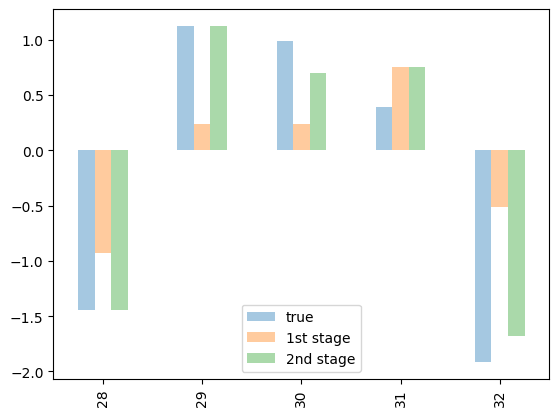

In [408]:
import time

T = 30
h = 3
num_free_vars = 7
df_true = pd.DataFrame(np.random.normal(0, 1, [T + h, num_free_vars]))
df_true["one"] = 1  # constant
df_true["sum"] = df_true.iloc[:, :].sum(axis=1)

# constraint in true data
df_true["sum"] - df_true.iloc[:, :-1].sum(axis=1)

num_variables = num_free_vars + 2

df = df_true.copy()
df[0].iloc[-h:] = np.nan
df[1].iloc[-h:] = np.nan
df["one"].iloc[-h:] = np.nan
C = np.ones([1, num_variables])
C[0, -1] = -1
d = 0
C_dict = {}
d_dict = {}
for i in range(T + h):
    C_dict[i] = C
    d_dict[i] = d

lag = 1
Tin = 5
df

start = time.time()
df2, df1, df0aug_fitted_model, df1_new, df2_new = ax_forecast(df, lag, Tin, C_dict, d_dict)
# df2,df1,df0aug_coef = ax_forecast(df, lag, Tin, C_dict, d_dict)


end = time.time()
print("time", end - start)

# forecast of the variable '0'
pd.DataFrame({"true": df_true[0], "1st stage": df1[0], "2nd stage": df2[0]}).tail(Tin).plot(
    alpha=0.4, kind="bar"
)

# the constraints are satisfied up to numerical error
sum(abs(df2["sum"] - df2.iloc[:, :-1].sum(axis=1)))

<Axes: >

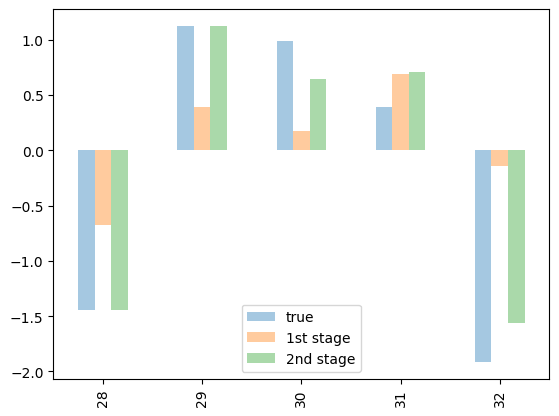

In [409]:
pd.DataFrame({"true": df_true[0], "1st stage": df1_new[0], "2nd stage": df2_new[0]}).tail(Tin).plot(
    alpha=0.4, kind="bar"
)

In [406]:
df1_new

,0,1,one,2,3,4,5,6,sum
0,-0.952235,0.732369,1.0,-0.055209,-0.763707,0.777641,1.029930,1.593604,3.362393
1,1.226409,0.132616,1.0,0.167552,-0.216636,-0.837764,0.722770,0.294869,2.489817
2,-1.409434,0.242786,1.0,0.960891,0.992687,-0.814740,-0.497528,0.082804,0.557466
3,-1.702764,-0.609389,1.0,-1.446265,-0.324959,1.211222,-1.049988,-0.109973,-3.032116
4,0.020911,0.889588,1.0,0.014636,0.737831,0.539528,1.176000,0.614566,4.993060
5,-0.330014,0.386383,1.0,-0.756128,-0.420103,0.274167,0.819477,-0.891577,0.082204
6,1.015293,-0.658218,1.0,0.210058,0.574885,0.637042,1.090136,0.425462,4.294657
7,0.806521,1.858792,1.0,1.496626,0.907284,-0.234611,-1.495466,1.655610,5.994757
8,-0.763754,-0.461393,1.0,-1.801238,-0.790139,0.551418,1.087354,0.587249,-0.590503
9,1.212635,1.106517,1.0,0.127090,-0.628780,0.639374,-1.624894,0.882588,2.714530


In [393]:
from pickle import load

with open("test123.picke", mode="rb") as file:
    result = load(file)
result

{'y_true_vals': [array([-1.21197215]),
  array([-0.57548674]),
  array([-0.13995865]),
  array([-1.84767976]),
  array([-1.52873479]),
  array([nan])],
 'y_forecasts': [0.11625291605793053,
  0.06312391331783208,
  0.0385619649992605,
  0.03195009036502955,
  0.05174169697088033,
  -0.08668145210266218],
 'X_pred': array([[ 0.76774375,  0.89563432,  0.69939624,  1.30638703,  1.60402531,
          6.44894389,  0.28507542, -1.71701799, -1.26259642,  1.61476758,
          0.79452662, -0.22823212]]),
 'y_true': array([[nan]]),
 'df0aug_u_np': array([[ 0.26420588,  0.18613587,  1.        ],
        [-0.30826014,  0.92658878,  1.        ],
        [-0.35628259, -1.36875785,  1.        ],
        [ 0.25516413, -1.92270933,  1.        ],
        [ 0.12423488,  0.09769731,  1.        ],
        [-1.18755832,  0.35295189,  1.        ],
        [ 1.57309026,  1.33543312,  1.        ],
        [-0.41527591, -0.09909327,  1.        ],
        [ 0.10066081, -0.50387999,  1.        ],
        [-0.200

In [399]:
result["t"]

29

In [398]:
DataFrame(result["df0aug_u_np"])

,0,1,2
0,0.264206,0.186136,1.0
1,-0.308260,0.926589,1.0
2,-0.356283,-1.368758,1.0
3,0.255164,-1.922709,1.0
4,0.124235,0.097697,1.0
5,-1.187558,0.352952,1.0
6,1.573090,1.335433,1.0
7,-0.415276,-0.099093,1.0
8,0.100661,-0.503880,1.0
9,-0.200824,0.574202,1.0


In [381]:
result["df0aug_u_np"][29, 0]

nan

In [368]:
DataFrame(result["df0aug_u_np"][29, :])

,0
0,NaN
1,NaN
2,NaN


In [361]:
DataFrame(result["df0aug_u_np"])

,0,1,2
0,0.382328,1.106757,1.0
1,0.542842,1.297901,1.0
2,-1.147034,-1.256970,1.0
3,0.599025,0.334742,1.0
4,-1.211350,-0.375865,1.0
5,0.782785,-0.263466,1.0
6,0.636032,-0.334834,1.0
7,0.293989,0.191641,1.0
8,-0.258482,-0.191497,1.0
9,0.699636,0.127212,1.0


In [353]:
cols_nans = result["df0aug"].isna().sum(axis=0) == 0
result["df0aug"].loc[:, cols_nans]

,2,3,4,5,6,sum,L1_2,L1_3,L1_4,L1_5,L1_6,L1_sum
1,1.043986,-0.099083,0.387998,-0.590974,-1.391317,-1.438240,0.070022,0.496893,-0.015106,-0.209693,-1.637207,-3.046975
2,-0.121760,-0.595443,-0.106101,1.420743,1.571904,6.277051,1.043986,-0.099083,0.387998,-0.590974,-1.391317,-1.438240
3,2.181402,-0.120373,0.104644,1.822567,0.423409,5.085635,-0.121760,-0.595443,-0.106101,1.420743,1.571904,6.277051
4,0.057605,-0.637431,0.413377,0.852215,-0.345738,1.303229,2.181402,-0.120373,0.104644,1.822567,0.423409,5.085635
5,0.640334,1.386484,1.519867,0.797860,0.695112,2.917937,0.057605,-0.637431,0.413377,0.852215,-0.345738,1.303229
6,0.059378,0.164180,-0.535281,-0.080497,0.931511,0.738680,0.640334,1.386484,1.519867,0.797860,0.695112,2.917937
7,-1.393477,-2.221018,-0.565544,0.522586,0.770766,-3.796076,0.059378,0.164180,-0.535281,-0.080497,0.931511,0.738680
8,1.582001,2.565193,0.639433,0.751037,-2.952736,2.022866,-1.393477,-2.221018,-0.565544,0.522586,0.770766,-3.796076
9,0.626001,0.616865,-0.978846,0.160263,0.699956,3.387014,1.582001,2.565193,0.639433,0.751037,-2.952736,2.022866
10,0.760308,1.080492,-0.525111,-0.071726,2.218434,4.522640,0.626001,0.616865,-0.978846,0.160263,0.699956,3.387014


In [341]:
DataFrame(result["df0aug_k_np"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.043986,-0.099083,0.387998,-0.590974,-1.391317,-1.438240,-0.996354,-1.755529,1.0,0.070022,0.496893,-0.015106,-0.209693,-1.637207,-3.046975
1,-0.121760,-0.595443,-0.106101,1.420743,1.571904,6.277051,-1.302137,-0.486714,1.0,1.043986,-0.099083,0.387998,-0.590974,-1.391317,-1.438240
2,2.181402,-0.120373,0.104644,1.822567,0.423409,5.085635,1.654914,1.452794,1.0,-0.121760,-0.595443,-0.106101,1.420743,1.571904,6.277051
3,0.057605,-0.637431,0.413377,0.852215,-0.345738,1.303229,0.329114,-0.655129,1.0,2.181402,-0.120373,0.104644,1.822567,0.423409,5.085635
4,0.640334,1.386484,1.519867,0.797860,0.695112,2.917937,1.091761,-1.128560,1.0,0.057605,-0.637431,0.413377,0.852215,-0.345738,1.303229
5,0.059378,0.164180,-0.535281,-0.080497,0.931511,0.738680,-2.617742,-0.503978,1.0,0.640334,1.386484,1.519867,0.797860,0.695112,2.917937
6,-1.393477,-2.221018,-0.565544,0.522586,0.770766,-3.796076,-0.593957,-0.206654,1.0,0.059378,0.164180,-0.535281,-0.080497,0.931511,0.738680
7,1.582001,2.565193,0.639433,0.751037,-2.952736,2.022866,-0.319045,-1.590345,1.0,-1.393477,-2.221018,-0.565544,0.522586,0.770766,-3.796076
8,0.626001,0.616865,-0.978846,0.160263,0.699956,3.387014,-0.121158,-1.440903,1.0,1.582001,2.565193,0.639433,0.751037,-2.952736,2.022866
9,0.760308,1.080492,-0.525111,-0.071726,2.218434,4.522640,1.718973,-0.456198,1.0,0.626001,0.616865,-0.978846,0.160263,0.699956,3.387014


In [322]:
result["df0aug"]

,0,1,one,2,3,4,5,6,7,8,...,L1_one,L1_2,L1_3,L1_4,L1_5,L1_6,L1_7,L1_8,L1_9,L1_sum
1,1.438336,0.620108,1.0,-1.677353,0.532890,-0.978697,-1.181097,-0.674714,0.546775,-0.876863,...,1.0,1.487441,1.216909,-1.757169,1.671418,-1.078804,-0.502765,-0.399951,-0.047759,3.625383
2,0.550183,0.944263,1.0,-0.204073,1.029821,1.130769,0.592276,-0.039866,0.037175,-0.550437,...,1.0,-1.677353,0.532890,-0.978697,-1.181097,-0.674714,0.546775,-0.876863,-0.932584,-2.183199
3,-1.269767,-0.219846,1.0,-0.658497,-1.089837,1.273352,-0.254063,1.082185,1.517959,0.024515,...,1.0,-0.204073,1.029821,1.130769,0.592276,-0.039866,0.037175,-0.550437,-0.081834,4.408277
4,-2.189081,0.906289,1.0,0.020831,-0.500989,-0.817933,-0.431705,-0.971526,0.315888,0.211829,...,1.0,-0.658497,-1.089837,1.273352,-0.254063,1.082185,1.517959,0.024515,-0.017886,1.388113
5,-0.316502,-1.718151,1.0,-0.173583,0.934884,-0.476984,-0.729409,-1.133040,0.858331,1.405667,...,1.0,0.020831,-0.500989,-0.817933,-0.431705,-0.971526,0.315888,0.211829,-0.449907,-2.906306
6,-0.284438,0.989589,1.0,1.626296,0.845852,-0.270048,-0.111766,-0.072297,0.534362,0.310913,...,1.0,-0.173583,0.934884,-0.476984,-0.729409,-1.133040,0.858331,1.405667,0.709663,0.360876
7,1.194344,-1.921729,1.0,-0.230322,-0.126646,0.401944,-1.989723,-0.164800,0.776955,-0.426009,...,1.0,1.626296,0.845852,-0.270048,-0.111766,-0.072297,0.534362,0.310913,0.564974,5.133438
8,0.106005,-0.082606,1.0,-0.709831,-0.926121,1.532501,0.683275,0.260141,-0.184855,-0.218171,...,1.0,-0.230322,-0.126646,0.401944,-1.989723,-0.164800,0.776955,-0.426009,-0.617197,-2.103182
9,-0.367388,-0.373642,1.0,-0.514408,-1.944405,-0.904817,0.152492,-1.953249,-0.995846,0.719143,...,1.0,-0.709831,-0.926121,1.532501,0.683275,0.260141,-0.184855,-0.218171,-1.728084,-0.267747
10,1.837513,0.122824,1.0,0.458078,-0.031667,0.356882,-0.449875,-1.251554,1.491676,-0.062182,...,1.0,-0.514408,-1.944405,-0.904817,0.152492,-1.953249,-0.995846,0.719143,-0.470943,-5.653063


In [269]:
result["df0aug_k_np"][:, np.isnan(result["df0aug_k_np"]).sum(axis=0) > 0]

array([[-0.37667076,  0.22226307,  1.        ],
       [-0.19712682, -0.20811137,  1.        ],
       [-1.21902476,  0.16876897,  1.        ],
       [-0.73058862,  1.21413511,  1.        ],
       [-1.70586005, -0.36305459,  1.        ],
       [-0.64378781, -0.02388586,  1.        ],
       [-0.71692642, -0.10023252,  1.        ],
       [-0.44555293, -0.09806573,  1.        ],
       [-0.15959007, -1.83780018,  1.        ],
       [ 2.72801485, -1.41599332,  1.        ],
       [-1.2881627 , -0.32943243,  1.        ],
       [ 1.34153647, -0.15363721,  1.        ],
       [ 0.00625928,  1.875383  ,  1.        ],
       [-0.37701886,  0.75099843,  1.        ],
       [ 0.37766959, -1.91714054,  1.        ],
       [-0.52098036, -0.84345249,  1.        ],
       [ 2.06735612,  1.00457266,  1.        ],
       [-0.94635034,  0.71693421,  1.        ],
       [ 0.09792679,  1.87118998,  1.        ],
       [ 1.88976564,  0.49645841,  1.        ],
       [ 0.19630786, -1.35796347,  1.   

In [249]:
result["df0aug_u_np"]

array([[-0.19712682, -0.20811137,  1.        ],
       [-1.21902476,  0.16876897,  1.        ],
       [-0.73058862,  1.21413511,  1.        ],
       [-1.70586005, -0.36305459,  1.        ],
       [-0.64378781, -0.02388586,  1.        ],
       [-0.71692642, -0.10023252,  1.        ],
       [-0.44555293, -0.09806573,  1.        ],
       [-0.15959007, -1.83780018,  1.        ],
       [ 2.72801485, -1.41599332,  1.        ],
       [-1.2881627 , -0.32943243,  1.        ],
       [ 1.34153647, -0.15363721,  1.        ],
       [ 0.00625928,  1.875383  ,  1.        ],
       [-0.37701886,  0.75099843,  1.        ],
       [ 0.37766959, -1.91714054,  1.        ],
       [-0.52098036, -0.84345249,  1.        ],
       [ 2.06735612,  1.00457266,  1.        ],
       [-0.94635034,  0.71693421,  1.        ],
       [ 0.09792679,  1.87118998,  1.        ],
       [ 1.88976564,  0.49645841,  1.        ],
       [ 0.19630786, -1.35796347,  1.        ],
       [ 0.53803133, -0.55623563,  1.   

In [210]:
# X_pred = df0aug_h.iloc[t, u:].values.reshape(1, -1)
result["df0aug_h"].iloc[-2, 3:]

2         0.727875
3        -0.339521
4         1.561893
5         1.690693
6        -0.879657
7         0.830952
8        -0.425138
9        -0.865770
sum       2.396068
L1_0     -0.052260
L1_1      0.096251
L1_one         NaN
L1_2     -1.655219
L1_3      0.612379
L1_4     -0.405132
L1_5      1.272916
L1_6      0.852649
L1_7      0.000464
L1_8      0.038564
L1_9      0.584963
L1_sum    2.207406
Name: 33, dtype: float64

In [176]:
result["X_pred"]

array([[ 0.08354264, -0.95120656, -1.18569916,  0.24978548, -1.72994239,
         0.12773331, -1.22079549, -0.25200254, -4.80914047,         nan,
                nan,         nan,  0.26880233,  0.00889625, -0.49698286,
         1.82404214,  1.42545412, -0.26852792, -0.21946235, -0.80402641,
         5.1150431 ]])

In [152]:
array([])[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Sample data
X = np.random.rand(100, 10)
y = np.random.rand(100)

# Define the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define the pipeline with StandardScaler and ElasticNetCV
pipeline = Pipeline([("scaler", StandardScaler()), ("elasticnet", ElasticNetCV(cv=tscv))])

# Fit the pipeline to the data
pipeline.fit(X, y)

# Print the best alpha and l1_ratio found by ElasticNetCV
elasticnet = pipeline.named_steps["elasticnet"]
print("Best alpha:", elasticnet.alpha_)
print("Best l1_ratio:", elasticnet.l1_ratio_)

Best alpha: 0.10908932461774137
Best l1_ratio: 0.5


In [76]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin


class NaiveForecaster(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        self.last_value_ = y[-1]  # Store the last value of the series
        return self

    def predict(self, X):
        return np.full(
            shape=(len(X),), fill_value=self.last_value_
        )  # Predict the last value for all instances


# Example usage:
# Sample data
X = np.arange(10).reshape(-1, 1)  # Dummy feature (not used in prediction)
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])  # Time series data

# Create the naive forecaster
naive_forecaster = NaiveForecaster()

# Fit the model
naive_forecaster.fit(X, y)

# Predict the next value(s)
X_test = np.arange(10, 15).reshape(-1, 1)  # Dummy feature for test
predictions = naive_forecaster.predict(X_test)

print("Predictions:", predictions)

Predictions: [9 9 9 9 9]


In [95]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error([1, 2], [0, 0])

1.5

In [ ]:
from typing import Self

import numpy as np
from joblib import parallel_backend
from numpy import array, full
from pandas import DataFrame
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline


class NaiveForecaster(BaseEstimator, RegressorMixin):
    """Naive forecaster to return the last value as prediction."""

    def fit(self, X, y) -> Self:
        self.last_value_ = y[-1]
        return self

    def predict(self, X) -> array:
        return full(shape=(len(X),), fill_value=self.last_value_)


def estimate_relationship(df: DataFrame, lag: int, Tin: int) -> tuple[DataFrame]:
    # Augment lags
    df0aug = augment_lag(df, lag)  # more columns, fewer rows

    # extract information on T,h,u,k from the shape of df0
    T_aug = sum(~np.isnan(df0aug).any(axis=1))  # length of historical data
    h = len(df0aug) - T_aug  # length of forecast horizon
    m_aug = df0aug.shape[1]  # number of all variables
    k_aug = sum(
        ~np.isnan(df0aug.iloc[: T_aug + 1, :]).any(axis=0)
    )  # number of known variables in T+1 including lags
    u = m_aug - k_aug  # m-k = m_aug - k_aug # number of unknown variables

    # create sub-dataframe and their np versions
    df0aug_u = df0aug.iloc[:, :u]  # not df0_u since rows are different from df0
    df0aug_k = df0aug.iloc[:, u:]
    df0aug_u_np = df0aug_u.to_numpy()
    df0aug_k_np = df0aug_k.to_numpy()

    # Step1 Prediction for T+1
    df0aug_h = df0aug.copy()  # hat, will be reshaped to df1 later
    df0aug_fitted_model = {}  # storage for fitted model
    df0aug_h_regularization = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_dim_reduction = df0aug.copy()  # dimension reduction = Principal Component
    df0aug_h_naive = df0aug.copy()  # regularization = Elastic Net CV
    df0aug_h_kernel_ridge = df0aug.copy()  # kernel ridge
    df0aug_h_svr = df0aug.copy()  # support vector regression
    df0aug_fitted_model_regularization = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ElasticNet fit
    df0aug_fitted_model_dim_reduction = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_kernel_ridge = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit
    df0aug_fitted_model_svr = pd.DataFrame(
        index=df0aug_u.index, columns=df0aug.columns
    )  # storage for ols + pca fit

    tscv = TimeSeriesSplit(n_splits=Tin)

    pipeline_linear_regression: Pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("PCA", PCA(n_components=0.9)),
            ("linreg", LinearRegression(fit_intercept=False)),
        ]
    )

    pipeline_naive = Pipeline(
        [
            ("naive", NaiveForecaster()),
        ]
    )

    pipeline_elastic_net = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "elasticnet",
                ElasticNetCV(
                    cv=tscv,
                    max_iter=100000,
                    fit_intercept=False,
                ),
            ),
        ]
    )

    pipeline_kernel_ridge = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("kernel_ridge", KernelRidge(kernel="rbf")),
        ]
    )

    param_distributions = {
        "alpha": loguniform(0.1, 1000),
        "gamma": uniform(0.5 * 1 / df.shape[1], 2 * 1 / df.shape[1]),
    }

    pipeline_kernel_ridge_cv = Pipeline(
        [
            (
                "randomsearch_cv_kernel",
                RandomizedSearchCV(
                    pipeline_kernel_ridge,
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                ),
            )
        ]
    )

    pipeline_svr = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("svr", SVR(kernel="rbf")),
        ]
    )

    param_distributions = {
        "C": loguniform(0.1, 1000),
    }

    pipeline_svr_cv = Pipeline(
        [
            (
                "randomsearch_cv_svr",
                RandomizedSearchCV(
                    pipeline_svr,
                    param_distributions=param_distributions,
                    n_iter=500,
                    random_state=0,
                    cv=tscv,
                ),
            )
        ]
    )

    model_list: list[Pipeline] = [
        pipeline_elastic_net,
        pipeline_naive,
        pipeline_linear_regression,
        pipeline_kernel_ridge_cv,
        pipeline_svr_cv,
    ]

    # unknown_variables: list[str] = ['var1', 'var2', '...']

    with parallel_backend():
        # for uvar in unknown_variables:
        for ui in list(range(u)):
            performance_across_models = dict()
            for model_num, model in enumerate(model_list):
                transformed_model = TransformedTargetRegressor(
                    regressor=model, transformer=StandardScaler()
                )
                y_true = df0aug_k_np[T_aug - Tin : T_aug + 1, :ui]
                y_forecasts = []
                for t in range(
                    T_aug - Tin, T_aug + 1
                ):  # forecast of T-Tin to T is for the weight matrix in the 2nd step
                    X = df[:t, :]
                    y = df[:t, ui].reshape(-1, 1)
                    X_pred = df0aug_k_np[t, :].reshape(1, -1)
                    y_true = df0aug_k_np[t, :ui].reshape(1, -1)

                    transformed_model.fit(X, y)
                    y_est = transformed_model.predict(X_pred)
                    y_forecasts.append(y_est)

                forecast_error = mean_absolute_error(y_true, y_forecasts)
                performance_across_models[model_num] = {
                    "forecast_error": forecast_error,
                    "fit_model": transformed_model,
                }

            # select the best model based on forecast error (lower is better, see sklearn.metrics)
            best_model_number = min(
                performance_across_models,
                key=lambda item: performance_across_models[item]["forecast_error"],
            )
            best_model = performance_across_models[best_model_number]["fit_model"]

            # forecast of T+2 to T+h, if h = 1 nothing will happen
            for t in range(-h + 1, 0):
                # drop lag variables and re-augment
                df0_h = df.copy()
                df0_h.iloc[-h - Tin :, :u] = df0aug_h.iloc[-h - Tin :, :u]
                df0aug_h = augment_lag(df0_h, lag)

                X_pred = df0aug_h.iloc[t, u:].values.reshape(1, -1)
                y_est = best_model.predict(X_pred)

                df0aug_h.iloc[t, ui] = y_est